# Popular Venue Model Notebook
#### Michael Harreld
#### Applied Data Science Capstone
#### 2019

This notebook explores and models the relationship between city data and venue popularity.

#### Import necessary Libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library
import re # reg ex library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

pd.set_option('display.max_rows',500)

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

# import decision trees scikit-learn libraries
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install python-graphviz --yes
import graphviz

from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split

import itertools

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Matplotlib version:  3.0.1
Libraries imported.


## Pull in city population, density, and location data
The first datasource is city population data from wikipedia.

#### Load the city data table from the wikipedia page *List of United States cities by population* into a data frame
Override the column labels to represent those in the page since they use split columns.

In [2]:
wiki_city_pop_tables=pd.read_html(io='https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population',match='Location',skiprows=1)
city_pop_df_full=wiki_city_pop_tables[0]
city_pop_df_full.columns=['2017 Rank','City','State','Population','2010 Census','Change','2016 land area imperial','2016 land area metric','2016 population density imperial',
                          'Density','Location']

#### Examine the city population dataframe
A few issues need to be cleaned up - some of the number columns have embedded text, some of of the text fields have superscripts in them, the location field is complicated and needs breaking apart, and there is redundant and unnecessary data.

In [3]:
city_pop_df_full.info()
city_pop_df_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 11 columns):
2017 Rank                           311 non-null int64
City                                311 non-null object
State                               311 non-null object
Population                          311 non-null int64
2010 Census                         311 non-null int64
Change                              311 non-null object
2016 land area imperial             311 non-null object
2016 land area metric               311 non-null object
2016 population density imperial    311 non-null object
Density                             311 non-null object
Location                            311 non-null object
dtypes: int64(3), object(8)
memory usage: 26.8+ KB


,2017 Rank,City,State,Population,2010 Census,Change,2016 land area imperial,2016 land area metric,2016 population density imperial,Density,Location
0,1,New York[6],New York,8622698,8175133,+5.47%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,2,Los Angeles,California,3999759,3792621,+5.46%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2716450,2695598,+0.77%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston[7],Texas,2312717,2100263,+10.12%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1626078,1445632,+12.48%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


#### Drop unnecessary columns in city population data
Looking at the columns note that 
* the rank is effectively redundant to the population, 
* the 2010 population data will not be needed because there is newer 2017 data
* the change data is probably second order and will be ignored,
* the land area columns are derivable from population and population density, and
* the imperial unit values are derivable from the metric ones.

Based on these observations, drop the redundant and unnecessary columns.

In [4]:
city_pop_df = city_pop_df_full.drop(columns=['2017 Rank','2010 Census','Change','2016 land area imperial','2016 land area metric','2016 population density imperial'])
city_pop_df.head()

,City,State,Population,Density,Location
0,New York[6],New York,8622698,"10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,Los Angeles,California,3999759,"3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,Chicago,Illinois,2716450,"4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,Houston[7],Texas,2312717,"1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,Phoenix,Arizona,1626078,"1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


#### Cleanup city data
Clean up the following issues:
* City data has superscript values that need to be removed
* Density data has embedded units that need to be removed
* Density data has commas that need to be removed
* Location has two values per field - need to throw away the minutes-seconds data and keep the decimal version


In [5]:
city_pop_df['City'].replace(regex=True,inplace=True,to_replace=r'\[.*\]', value=r'')
city_pop_df['Density'] = city_pop_df['Density'].str.rstrip('/km2')
city_pop_df['Density'].replace(regex=True,inplace=True,to_replace=r',', value=r'')
city_pop_df['Location'].replace(regex=True,inplace=True,to_replace=r'.*/ ', value=r'')
city_pop_df.head()

,City,State,Population,Density,Location
0,New York,New York,8622698,10933,﻿40.6635°N 73.9387°W
1,Los Angeles,California,3999759,3276,﻿34.0194°N 118.4108°W
2,Chicago,Illinois,2716450,4600,﻿41.8376°N 87.6818°W
3,Houston,Texas,2312717,1395,﻿29.7866°N 95.3909°W
4,Phoenix,Arizona,1626078,1200,﻿33.5722°N 112.0901°W


#### Parse out location data
Location data in a complex string so create functions to extract latitude and longitude from such a structured string.
Assume all data will be in the western hemisphere north of the equator since all data is from United States.

In [6]:
def convert_coord_to_lat(coord):
    split_parts = re.split('[^\d.]+',coord)
    latitude = float(split_parts[1])
    return latitude
def convert_coord_to_long(coord):
    split_parts = re.split('[^\d.]+',coord)
    longitude = -float(split_parts[2]) # assuming everything in western hemisphere so use negative longitudes
    return longitude

Apply the functions to extract out the latitude and longitude data into new columns.

In [7]:
city_pop_df['Latitude'] = city_pop_df['Location'].apply(convert_coord_to_lat)
city_pop_df['Longitude'] = city_pop_df['Location'].apply(convert_coord_to_long)
city_pop_df.head()

,City,State,Population,Density,Location,Latitude,Longitude
0,New York,New York,8622698,10933,﻿40.6635°N 73.9387°W,40.6635,-73.9387
1,Los Angeles,California,3999759,3276,﻿34.0194°N 118.4108°W,34.0194,-118.4108
2,Chicago,Illinois,2716450,4600,﻿41.8376°N 87.6818°W,41.8376,-87.6818
3,Houston,Texas,2312717,1395,﻿29.7866°N 95.3909°W,29.7866,-95.3909
4,Phoenix,Arizona,1626078,1200,﻿33.5722°N 112.0901°W,33.5722,-112.0901


Finally, drop the original Location column and convert the Density column to be numeric.

In [8]:
city_pop_df = city_pop_df.drop(columns=['Location'])
city_pop_df['Density'] = pd.to_numeric(city_pop_df['Density'])
city_pop_df.head()

,City,State,Population,Density,Latitude,Longitude
0,New York,New York,8622698,10933,40.6635,-73.9387
1,Los Angeles,California,3999759,3276,34.0194,-118.4108
2,Chicago,Illinois,2716450,4600,41.8376,-87.6818
3,Houston,Texas,2312717,1395,29.7866,-95.3909
4,Phoenix,Arizona,1626078,1200,33.5722,-112.0901


Reviewing the city population column types to ensure they are all correct.

In [9]:
city_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 6 columns):
City          311 non-null object
State         311 non-null object
Population    311 non-null int64
Density       311 non-null int64
Latitude      311 non-null float64
Longitude     311 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 14.7+ KB


## Pull and process venue data
The Foursquare API will be used for each city in turn to build up local venue data.

#### Set data size parameters
Set ROW_COUNT to be how many cities and LIMIT to be number of venues per city to be analyzed.

In [10]:
ROW_COUNT=75
LIMIT=50

Create a new dataframe for combined city data.

In [11]:
city_df = city_pop_df.head(ROW_COUNT)

Prepare for use of Foursquare API by configuring credentials.

In [12]:
CLIENT_ID = '3DWHLHPC5DDWIQLMZUYI3Q3CLABO2U30YSUZXF4YU4DUEVIQ' # your Foursquare ID
CLIENT_SECRET = 'XLFR1LOMD5MCLSA41GR4HOE23RMV3GZKOPVJQLTMVTLYP0DL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 3DWHLHPC5DDWIQLMZUYI3Q3CLABO2U30YSUZXF4YU4DUEVIQ
CLIENT_SECRET:XLFR1LOMD5MCLSA41GR4HOE23RMV3GZKOPVJQLTMVTLYP0DL


Create a new function that will return a dataframe containing venues close to a passed location using Foursquare

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&intent=global'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name,lat,lng,v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City','City Latitude','City Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    
    return(nearby_venues)

#### Load all city venue data
Pass all city names and locations into the function to extract a new dataframe containing venues

In [14]:
city_venues = getNearbyVenues(names=city_df['City'],latitudes=city_df['Latitude'],longitudes=city_df['Longitude'])
city_venues.head()

New York
Los Angeles
Chicago
Houston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin
Jacksonville
San Francisco
Columbus
Fort Worth
Indianapolis
Charlotte
Seattle
Denver
Washington
Boston
El Paso
Detroit
Nashville
Memphis
Portland
Oklahoma City
Las Vegas
Louisville
Baltimore
Milwaukee
Albuquerque
Tucson
Fresno
Sacramento
Mesa
Kansas City
Atlanta
Long Beach
Omaha
Raleigh
Colorado Springs
Miami
Virginia Beach
Oakland
Minneapolis
Tulsa
Arlington
New Orleans
Wichita
Cleveland
Tampa
Bakersfield
Aurora
Anaheim
Honolulu
Santa Ana
Riverside
Corpus Christi
Lexington
Stockton
St. Louis
Saint Paul
Henderson
Pittsburgh
Cincinnati
Anchorage
Greensboro
Plano
Newark
Lincoln
Orlando
Irvine
Toledo
Jersey City


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,40.6635,-73.9387,Izzy's Brooklyn Smokehouse,40.664869,-73.937023,BBQ Joint
1,New York,40.6635,-73.9387,Ali's Roti Shop,40.666436,-73.931346,Caribbean Restaurant
2,New York,40.6635,-73.9387,Sweet Expressions,40.668382,-73.942337,Candy Store
3,New York,40.6635,-73.9387,Mama Louisa's Hero Shoppe,40.659496,-73.947519,Sandwich Place
4,New York,40.6635,-73.9387,The Market Place,40.662153,-73.943010,Grocery Store


## Calculate venue category frequency per city

Calculate the fractions of venue categories per city to determine venue popularity in each city

Grouping by venue category to show counts per venue across all cities.

In [15]:
city_venues.groupby('Venue Category').count().head(10)

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
ATM,5,5,5,5,5,5
Accessories Store,5,5,5,5,5,5
Afghan Restaurant,2,2,2,2,2,2
African Restaurant,3,3,3,3,3,3
Airport,8,8,8,8,8,8
Airport Food Court,1,1,1,1,1,1
Airport Lounge,3,3,3,3,3,3
Airport Service,1,1,1,1,1,1
American Restaurant,210,210,210,210,210,210


In [16]:
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

There are 389 uniques categories.


Create a new *One Hot* table that has a dedicated column with 0 or 1 for each venue category representing whether a particular city's venue has that category

In [17]:
city_venue_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")
city_venue_onehot['City'] = city_venues['City'] 
fixed_columns = [city_venue_onehot.columns[-1]] + list(city_venue_onehot.columns[:-1])
city_venue_onehot = city_venue_onehot[fixed_columns]
city_venue_onehot.head()

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group the *One Hot* table by city and take the mean of each venue category column to end up with the fractional occurrence of each venue category within each city.

In [18]:
city_venue_grouped = city_venue_onehot.groupby('City').mean().reset_index()
city_venue_grouped.head(10)

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Albuquerque,0.0000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0600,...,0.0,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.0
1,Anaheim,0.0000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0500,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2,Anchorage,0.0000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0300,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0
3,Arlington,0.0000,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0300,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
4,Atlanta,0.0000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0300,...,0.0,0.0,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.0
5,Aurora,0.0000,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0500,...,0.0,0.0,0.00,0.00,0.00,0.02,0.00,0.01,0.00,0.0
6,Austin,0.0000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0100,...,0.0,0.0,0.01,0.00,0.00,0.01,0.00,0.03,0.00,0.0
7,Bakersfield,0.0000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0400,...,0.0,0.0,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.0
8,Baltimore,0.0000,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0200,...,0.0,0.0,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.0
9,Boston,0.0125,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0375,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


## Extract most popular venue categories for each city
Print out some of the top categories with their fraction for each city to begin to understand the data.

In [19]:
num_top_venues = 5

for city in city_venue_grouped['City']:
    temp = city_venue_grouped[city_venue_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True)
    city_line = city + ":\t"
    for i in range(5):
        city_line += temp.iloc[i]['venue'] + "(" + str(temp.iloc[i]['freq'])+ "), "
#    city_line +=" : "           +temp.iloc[0]['venue'] + "(" + str(temp.iloc[0]['freq'])+ "),"           +temp.iloc[1]['venue'] + "(" + str(temp.iloc[1]['freq'])+ "),"           +temp.iloc[2]['venue'] + "(" + str(temp.iloc[2]['freq'])+ ")" 
    print(city_line)

Albuquerque:	Mexican Restaurant(0.09), Brewery(0.08), Hotel(0.07), American Restaurant(0.06), Coffee Shop(0.06), 
Anaheim:	Mexican Restaurant(0.08), Grocery Store(0.06), Park(0.05), Sandwich Place(0.05), American Restaurant(0.05), 
Anchorage:	Coffee Shop(0.09), Pizza Place(0.08), Mexican Restaurant(0.06), Fast Food Restaurant(0.05), Gym(0.04), 
Arlington:	Sandwich Place(0.05), Burger Joint(0.04), American Restaurant(0.03), Liquor Store(0.03), Deli / Bodega(0.03), 
Atlanta:	Park(0.05), Aquarium(0.05), Art Gallery(0.03), Trail(0.03), American Restaurant(0.03), 
Aurora:	Coffee Shop(0.06), American Restaurant(0.05), Grocery Store(0.04), Convenience Store(0.04), Liquor Store(0.03), 
Austin:	Sandwich Place(0.08), Coffee Shop(0.05), Pizza Place(0.04), Park(0.04), BBQ Joint(0.03), 
Bakersfield:	Pizza Place(0.06), Burger Joint(0.06), Mexican Restaurant(0.06), Coffee Shop(0.06), Sandwich Place(0.05), 
Baltimore:	Coffee Shop(0.06), Italian Restaurant(0.04), Café(0.04), New American Restaurant(0.0

## Perform clustering of cities based on similarity of top venue categories
To explore the venue category data, do a clustering of cities to see whether there are regional patterns of popularity.

Create a function that will return the most common venues from a city given a row of the grouped city venue dataframe

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe which contains a row for each city and a column for each of the top venue categories within that city. 

In [21]:
num_top_venues = 10
columns = ['City']
for ind in np.arange(num_top_venues):
    columns.append('Venue Rank {}'.format(ind+1))

city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_venue_grouped['City']

for ind in np.arange(city_venue_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_venue_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,Albuquerque,Mexican Restaurant,Brewery,Hotel,Coffee Shop,American Restaurant,Sandwich Place,Pizza Place,New American Restaurant,Farmers Market,Plaza
1,Anaheim,Mexican Restaurant,Grocery Store,Sandwich Place,Park,American Restaurant,Burger Joint,Coffee Shop,Pizza Place,Trail,Thai Restaurant
2,Anchorage,Coffee Shop,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Gym,Trail,Ice Cream Shop,American Restaurant,Sandwich Place,Bakery
3,Arlington,Sandwich Place,Burger Joint,Breakfast Spot,Mexican Restaurant,Liquor Store,Fried Chicken Joint,Deli / Bodega,Furniture / Home Store,American Restaurant,Sushi Restaurant
4,Atlanta,Aquarium,Park,Trail,Art Gallery,Seafood Restaurant,American Restaurant,Fast Food Restaurant,Restaurant,Sushi Restaurant,Dive Bar


Perform clustering analysis to find the corresponding cluster for each city

In [22]:
# set number of clusters
kclusters = 5

city_grouped_clustering = city_venue_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 3, 0, 0, 2, 0, 0, 3, 2, 2, 0, 3, 0, 2, 0, 2, 4, 2, 0, 2, 3, 3,
       3, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 3, 2, 0, 3, 2, 2, 2,
       0, 0, 3, 3, 2, 0, 0, 0, 3, 2, 0, 2, 0, 0, 0, 2, 3, 0, 1, 0, 3, 2,
       2, 0, 0, 0, 0, 3, 0, 2, 2], dtype=int32)

Merge together the original city data, the cluster data, and the venue rank data into one dataframe

In [23]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = city_df

# merge venues data to add latitude/longitude for each city
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

city_merged.head() # check the last columns!

,City,State,Population,Density,Latitude,Longitude,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,New York,New York,8622698,10933,40.6635,-73.9387,0,Caribbean Restaurant,Café,Bakery,Pizza Place,Deli / Bodega,Fast Food Restaurant,Pharmacy,Bagel Shop,Discount Store,Vegetarian / Vegan Restaurant
1,Los Angeles,California,3999759,3276,34.0194,-118.4108,0,Pizza Place,Coffee Shop,Thai Restaurant,Grocery Store,Taco Place,Mexican Restaurant,Café,Burger Joint,Italian Restaurant,Mediterranean Restaurant
2,Chicago,Illinois,2716450,4600,41.8376,-87.6818,3,Mexican Restaurant,Art Gallery,Diner,Taco Place,Italian Restaurant,Hot Dog Joint,Grocery Store,Pizza Place,Coffee Shop,Brewery
3,Houston,Texas,2312717,1395,29.7866,-95.3909,2,Mexican Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop,American Restaurant,Art Gallery,Trail,New American Restaurant,Gastropub,Bistro
4,Phoenix,Arizona,1626078,1200,33.5722,-112.0901,3,Mexican Restaurant,Trail,Convenience Store,Sandwich Place,Steakhouse,Grocery Store,Ice Cream Shop,Bakery,Breakfast Spot,Bookstore


## Exploration of relationship of location data to venue popularity
Visualize the cluster category for each city on a map of the United States.

The patterns in the cluster distribution give insight into whether location has a feasible relationship to popular venue category.

In [24]:
us_latitude=39
us_longitude=-105
# create map
map_clusters = folium.Map(location=[us_latitude, us_longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color=rainbow[cluster-1],fill=True,fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine each cluster in turn and gain some insight into what they have in common

In [25]:
city_merged.loc[city_merged['Cluster Labels'] == 0, city_merged.columns[[0] + list(range(7, city_merged.shape[1]))]]

,City,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,New York,Caribbean Restaurant,Café,Bakery,Pizza Place,Deli / Bodega,Fast Food Restaurant,Pharmacy,Bagel Shop,Discount Store,Vegetarian / Vegan Restaurant
1,Los Angeles,Pizza Place,Coffee Shop,Thai Restaurant,Grocery Store,Taco Place,Mexican Restaurant,Café,Burger Joint,Italian Restaurant,Mediterranean Restaurant
5,Philadelphia,Fast Food Restaurant,Discount Store,Pizza Place,Bar,Donut Shop,Art Gallery,Caribbean Restaurant,Breakfast Spot,Grocery Store,Diner
7,San Diego,Sushi Restaurant,Sandwich Place,Japanese Restaurant,Mexican Restaurant,Chinese Restaurant,Deli / Bodega,Coffee Shop,Middle Eastern Restaurant,Korean Restaurant,Vietnamese Restaurant
9,San Jose,Vietnamese Restaurant,Coffee Shop,Bubble Tea Shop,Mexican Restaurant,Fast Food Restaurant,Park,Grocery Store,Sushi Restaurant,Seafood Restaurant,Pizza Place
10,Austin,Sandwich Place,Coffee Shop,Park,Pizza Place,Ice Cream Shop,Taco Place,Pharmacy,Food Truck,Mexican Restaurant,BBQ Joint
11,Jacksonville,Fast Food Restaurant,Brewery,Sandwich Place,Park,Bar,Coffee Shop,Discount Store,Pub,Café,Food Truck
16,Charlotte,Pizza Place,Bakery,Coffee Shop,Mexican Restaurant,American Restaurant,Sandwich Place,Mediterranean Restaurant,Gym / Fitness Center,Italian Restaurant,Park
18,Denver,Coffee Shop,Mexican Restaurant,Sandwich Place,Pizza Place,Brewery,Gym / Fitness Center,Hotel,Burger Joint,Italian Restaurant,Restaurant
27,Las Vegas,American Restaurant,Sandwich Place,Coffee Shop,Park,Breakfast Spot,Fast Food Restaurant,Mexican Restaurant,Grocery Store,Cosmetics Shop,Sushi Restaurant


In [26]:
city_merged.loc[city_merged['Cluster Labels'] == 1, city_merged.columns[[0] + list(range(7, city_merged.shape[1]))]]

,City,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
12,San Francisco,Harbor / Marina,Outdoors & Recreation,Scenic Lookout,River,Fabric Shop,Donut Shop,Drive-in Theater,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


In [27]:
city_merged.loc[city_merged['Cluster Labels'] == 2, city_merged.columns[[0] + list(range(7, city_merged.shape[1]))]]

,City,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
3,Houston,Mexican Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop,American Restaurant,Art Gallery,Trail,New American Restaurant,Gastropub,Bistro
8,Dallas,Bar,Mexican Restaurant,Burger Joint,Dive Bar,Coffee Shop,Thai Restaurant,BBQ Joint,Park,Rock Club,Pizza Place
13,Columbus,Bar,Bakery,Pizza Place,Café,Gastropub,Coffee Shop,Cocktail Bar,American Restaurant,Brewery,Antique Shop
15,Indianapolis,Bar,Brewery,Coffee Shop,New American Restaurant,Gastropub,Pub,Gym,Comedy Club,American Restaurant,Theater
17,Seattle,Coffee Shop,Exhibit,Bar,Mexican Restaurant,Theater,Plaza,Pizza Place,Sculpture Garden,Beer Bar,Seafood Restaurant
19,Washington,American Restaurant,Gym / Fitness Center,Hotel,Coffee Shop,Bar,Ice Cream Shop,Italian Restaurant,New American Restaurant,Cocktail Bar,Bakery
20,Boston,Park,Bar,Seafood Restaurant,Beach,Mexican Restaurant,Diner,Hotel,Coffee Shop,Italian Restaurant,American Restaurant
22,Detroit,Bar,Discount Store,Fast Food Restaurant,Café,Pizza Place,Pharmacy,Art Museum,Coffee Shop,American Restaurant,Clothing Store
23,Nashville,Bar,Coffee Shop,Hotel,Restaurant,Music Venue,American Restaurant,Cocktail Bar,Italian Restaurant,Steakhouse,Pizza Place
24,Memphis,Bar,Café,Discount Store,Coffee Shop,Pizza Place,BBQ Joint,American Restaurant,Burger Joint,Mexican Restaurant,Restaurant


In [28]:
city_merged.loc[city_merged['Cluster Labels'] == 3, city_merged.columns[[0] + list(range(7, city_merged.shape[1]))]]

,City,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
2,Chicago,Mexican Restaurant,Art Gallery,Diner,Taco Place,Italian Restaurant,Hot Dog Joint,Grocery Store,Pizza Place,Coffee Shop,Brewery
4,Phoenix,Mexican Restaurant,Trail,Convenience Store,Sandwich Place,Steakhouse,Grocery Store,Ice Cream Shop,Bakery,Breakfast Spot,Bookstore
6,San Antonio,Mexican Restaurant,Burger Joint,Taco Place,Grocery Store,Fast Food Restaurant,Coffee Shop,BBQ Joint,American Restaurant,Discount Store,Pizza Place
14,Fort Worth,Mexican Restaurant,Bar,Steakhouse,American Restaurant,Burger Joint,Hotel,New American Restaurant,BBQ Joint,Historic Site,Lounge
21,El Paso,Mexican Restaurant,Gas Station,Pizza Place,Fast Food Restaurant,Burger Joint,Discount Store,Steakhouse,Diner,Gym,Chinese Restaurant
28,Louisville,Mexican Restaurant,Sandwich Place,Department Store,Pharmacy,Fast Food Restaurant,Discount Store,American Restaurant,Chinese Restaurant,Pet Store,Gym / Fitness Center
33,Fresno,Mexican Restaurant,Coffee Shop,Bar,American Restaurant,Burger Joint,Ice Cream Shop,Pharmacy,Grocery Store,Bakery,Fast Food Restaurant
42,Miami,Cuban Restaurant,Smoke Shop,Mexican Restaurant,Latin American Restaurant,Pharmacy,Spanish Restaurant,Pizza Place,Seafood Restaurant,Grocery Store,Bakery
44,Oakland,Mexican Restaurant,Café,Coffee Shop,Grocery Store,Vietnamese Restaurant,Middle Eastern Restaurant,Flea Market,Brewery,Food Truck,Pizza Place
46,Tulsa,Burger Joint,Mexican Restaurant,Convenience Store,Clothing Store,Coffee Shop,Cosmetics Shop,Ice Cream Shop,Sandwich Place,Diner,Furniture / Home Store


In [29]:
city_merged.loc[city_merged['Cluster Labels'] == 4, city_merged.columns[[0] + list(range(7, city_merged.shape[1]))]]

,City,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
58,Corpus Christi,Resort,Beach,Harbor / Marina,Boat or Ferry,Golf Course,Seafood Restaurant,Hotel Pool,Hotel,Flea Market,Exhibit


## Exploration of relationships of population and density to venue popularity
Explore the data further, to determine which independent values have a feasible relationship to venue popularity.

Start with previous generated dataframe which contains all accumulated city information

In [30]:
city_merged.head()

,City,State,Population,Density,Latitude,Longitude,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,New York,New York,8622698,10933,40.6635,-73.9387,0,Caribbean Restaurant,Café,Bakery,Pizza Place,Deli / Bodega,Fast Food Restaurant,Pharmacy,Bagel Shop,Discount Store,Vegetarian / Vegan Restaurant
1,Los Angeles,California,3999759,3276,34.0194,-118.4108,0,Pizza Place,Coffee Shop,Thai Restaurant,Grocery Store,Taco Place,Mexican Restaurant,Café,Burger Joint,Italian Restaurant,Mediterranean Restaurant
2,Chicago,Illinois,2716450,4600,41.8376,-87.6818,3,Mexican Restaurant,Art Gallery,Diner,Taco Place,Italian Restaurant,Hot Dog Joint,Grocery Store,Pizza Place,Coffee Shop,Brewery
3,Houston,Texas,2312717,1395,29.7866,-95.3909,2,Mexican Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop,American Restaurant,Art Gallery,Trail,New American Restaurant,Gastropub,Bistro
4,Phoenix,Arizona,1626078,1200,33.5722,-112.0901,3,Mexican Restaurant,Trail,Convenience Store,Sandwich Place,Steakhouse,Grocery Store,Ice Cream Shop,Bakery,Breakfast Spot,Bookstore


## Population and density related to venue category
Looking first at population and density, create a new dataframe containing the number one venue category of each city along with its population and density

In [31]:
top_venue = city_merged[['Venue Rank 1', 'Population','Density']].copy()
top_venue.head()

,Venue Rank 1,Population,Density
0,Caribbean Restaurant,8622698,10933
1,Pizza Place,3999759,3276
2,Mexican Restaurant,2716450,4600
3,Mexican Restaurant,2312717,1395
4,Mexican Restaurant,1626078,1200


Group this data by venue category and find the mean of population and density for each category.

In [32]:
top_venue_group_mean = top_venue.groupby(['Venue Rank 1']).mean()
top_venue_group_mean.head()

,Population,Density
Venue Rank 1,,
American Restaurant,5.121057e+05,1738.166667
Aquarium,4.862900e+05,1366.000000
Bar,6.620958e+05,1937.545455
Burger Joint,4.018000e+05,791.000000
Caribbean Restaurant,8.622698e+06,10933.000000


Plot the mean population and density per venue category to get an idea whether there is a feasible relationship between mean population and density with most popular venue category.

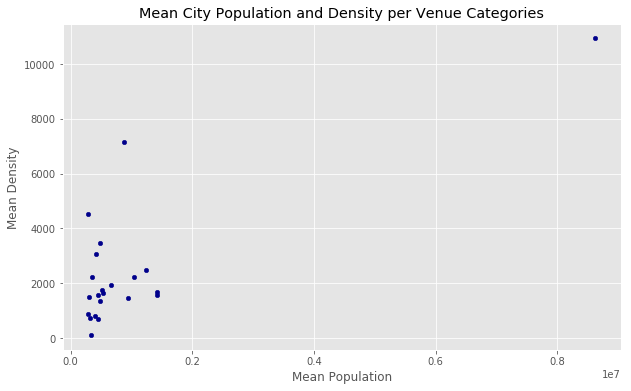

In [33]:
top_venue_group_mean.plot(kind='scatter', x='Population', y='Density', figsize=(10, 6), color='darkblue')

plt.title('Mean City Population and Density per Venue Categories')
plt.xlabel('Mean Population')
plt.ylabel('Mean Density')

plt.show()

## Modeling of venue popularity from population, density, and location

Since population, density, and location all showed feasible relationships to venue popularity, use them as independent variables in the modeling.
The target variable is most popular venue category.
Choose a decision tree since the independent variable is categorical.

Review previous generated dataframe which contains all accumulated city information

In [34]:
city_merged.head()

,City,State,Population,Density,Latitude,Longitude,Cluster Labels,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
0,New York,New York,8622698,10933,40.6635,-73.9387,0,Caribbean Restaurant,Café,Bakery,Pizza Place,Deli / Bodega,Fast Food Restaurant,Pharmacy,Bagel Shop,Discount Store,Vegetarian / Vegan Restaurant
1,Los Angeles,California,3999759,3276,34.0194,-118.4108,0,Pizza Place,Coffee Shop,Thai Restaurant,Grocery Store,Taco Place,Mexican Restaurant,Café,Burger Joint,Italian Restaurant,Mediterranean Restaurant
2,Chicago,Illinois,2716450,4600,41.8376,-87.6818,3,Mexican Restaurant,Art Gallery,Diner,Taco Place,Italian Restaurant,Hot Dog Joint,Grocery Store,Pizza Place,Coffee Shop,Brewery
3,Houston,Texas,2312717,1395,29.7866,-95.3909,2,Mexican Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop,American Restaurant,Art Gallery,Trail,New American Restaurant,Gastropub,Bistro
4,Phoenix,Arizona,1626078,1200,33.5722,-112.0901,3,Mexican Restaurant,Trail,Convenience Store,Sandwich Place,Steakhouse,Grocery Store,Ice Cream Shop,Bakery,Breakfast Spot,Bookstore


Create a new dataframe containing only the columns of interest to the model.

In [35]:
top_venue_data = city_merged[['Venue Rank 1','Population','Density','Latitude','Longitude']].copy()
top_venue_data.head()

,Venue Rank 1,Population,Density,Latitude,Longitude
0,Caribbean Restaurant,8622698,10933,40.6635,-73.9387
1,Pizza Place,3999759,3276,34.0194,-118.4108
2,Mexican Restaurant,2716450,4600,41.8376,-87.6818
3,Mexican Restaurant,2312717,1395,29.7866,-95.3909
4,Mexican Restaurant,1626078,1200,33.5722,-112.0901


## Training the decision tree model
Hold back a fraction of the data for testing the validity after training.

In [36]:
TEST_FRACTION = 0.2
TREE_DEPTH = 4

Divide the data into training and test sets.

In [37]:
top_venue_train, top_venue_test = train_test_split(top_venue_data,test_size=TEST_FRACTION)
print('training set size={}, test set size={}'.format(len(top_venue_train),len(top_venue_test)))

training set size=60, test set size=15


Fit the model to the training data.

In [38]:
top_venues = top_venue_train["Venue Rank 1"]
city_info = top_venue_train.iloc[:,1:]

venue_tree = tree.DecisionTreeClassifier(max_depth=TREE_DEPTH)
venue_tree.fit(city_info, top_venues)

print("Decision tree model saved to venue_tree!")

Decision tree model saved to venue_tree!


Visualize the decision tree.

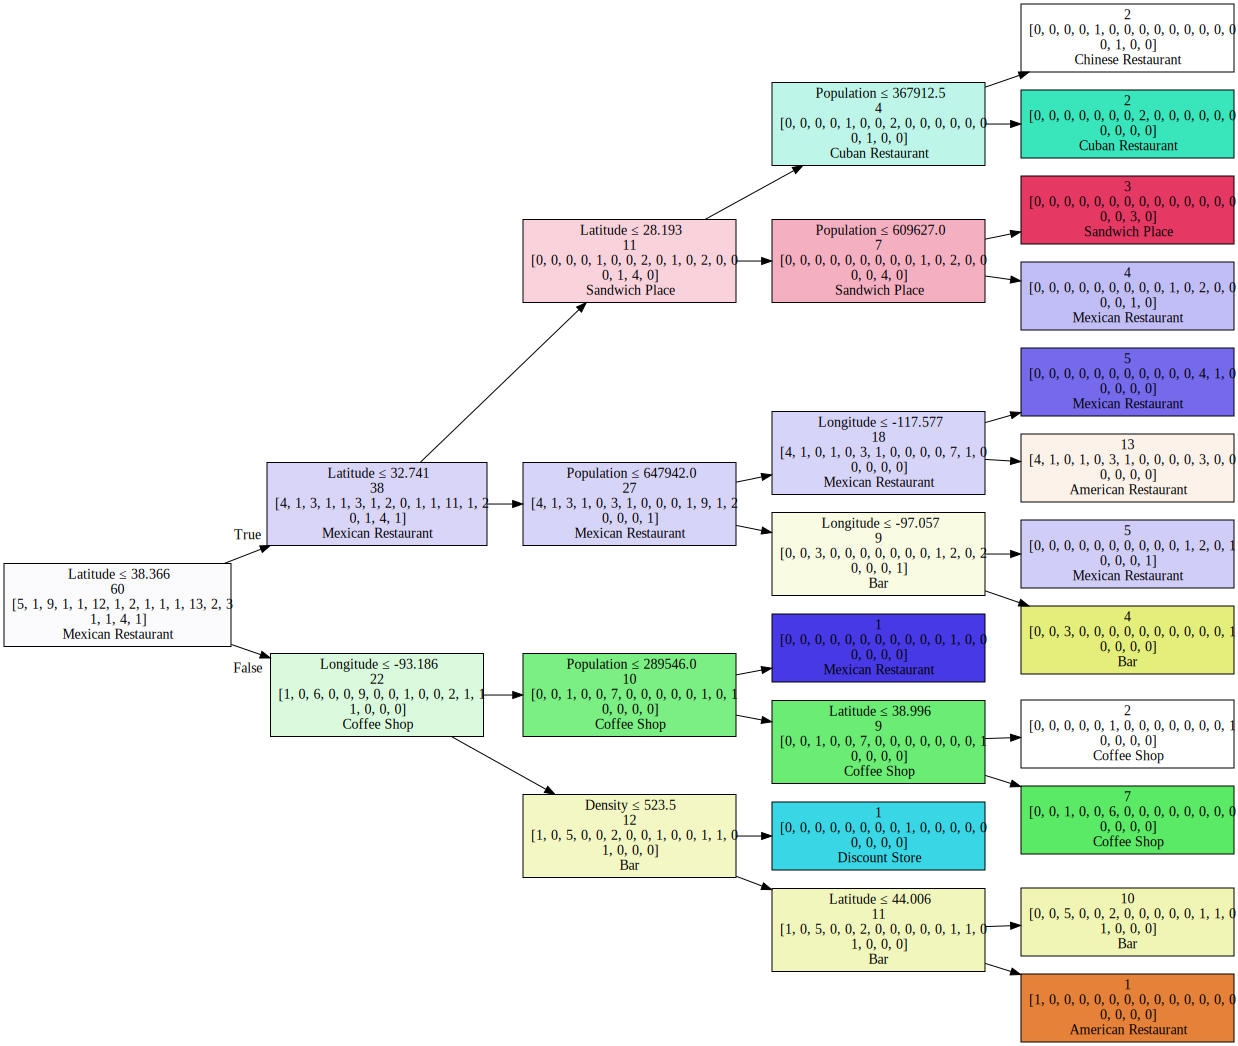

In [39]:
export_graphviz(venue_tree,
                feature_names=list(city_info.columns.values),
                out_file="venue_tree.dot",
                class_names=np.unique(top_venues),
                filled=True,
                node_ids=False,
                special_characters=True,
                impurity=False,
                label="none",
                leaves_parallel=False,
                rotate=True)

with open("venue_tree.dot") as venue_tree_image:
    venue_tree_graph = venue_tree_image.read()
graphviz.Source(venue_tree_graph)

## Validate the model
Get the test city dataframe

In [40]:
city_info_test = top_venue_test.iloc[:,1:]
city_info_test

,Population,Density,Latitude,Longitude
65,301301,1490,39.1402,-84.5058
52,380874,976,35.3212,-119.0183
38,469450,3609,33.8092,-118.1553
61,308626,1939,38.6357,-90.2446
60,310496,19,37.9763,-121.3133
13,879170,1520,39.9852,-82.9848
7,1419516,1670,32.8153,-117.1350
19,693972,4304,38.9041,-77.0172
18,704621,1746,39.7619,-104.8811
0,8622698,10933,40.6635,-73.9387


Run the test city data through the model to calculate the predicted top venue for each test city.

In [41]:
top_venue_pred = venue_tree.predict(city_info_test)
top_venue_pred

array(['Bar', 'Mexican Restaurant', 'Mexican Restaurant', 'Bar',
       'Mexican Restaurant', 'Bar', 'Mexican Restaurant', 'Bar',
       'Coffee Shop', 'Bar', 'Sandwich Place', 'American Restaurant',
       'Mexican Restaurant', 'Bar', 'American Restaurant'], dtype=object)

Begin to construct a dataframe to compare the predicted to actual venue category.

Start with the test city data.

In [42]:
test_eval = city_info_test.copy()
test_eval.head()

,Population,Density,Latitude,Longitude
65,301301,1490,39.1402,-84.5058
52,380874,976,35.3212,-119.0183
38,469450,3609,33.8092,-118.1553
61,308626,1939,38.6357,-90.2446
60,310496,19,37.9763,-121.3133


Add in the predicted top venue.

In [43]:
test_eval['Predicted Top Venue'] = top_venue_pred
test_eval.head()

,Population,Density,Latitude,Longitude,Predicted Top Venue
65,301301,1490,39.1402,-84.5058,Bar
52,380874,976,35.3212,-119.0183,Mexican Restaurant
38,469450,3609,33.8092,-118.1553,Mexican Restaurant
61,308626,1939,38.6357,-90.2446,Bar
60,310496,19,37.9763,-121.3133,Mexican Restaurant


Merge in the actual venue ranks

In [44]:
test_eval_merged = test_eval.join(city_merged[['Venue Rank 1', 'Venue Rank 2', 'Venue Rank 3', 'Venue Rank 4', 'Venue Rank 5', 'Venue Rank 6', 'Venue Rank 7', 'Venue Rank 8', 'Venue Rank 9', 'Venue Rank 10']])
test_eval_merged.head()

,Population,Density,Latitude,Longitude,Predicted Top Venue,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10
65,301301,1490,39.1402,-84.5058,Bar,Zoo Exhibit,Pizza Place,Bar,Sandwich Place,Coffee Shop,Sushi Restaurant,Hotel,Indian Restaurant,Ice Cream Shop,Burrito Place
52,380874,976,35.3212,-119.0183,Mexican Restaurant,Pizza Place,Burger Joint,Coffee Shop,Mexican Restaurant,Sandwich Place,Clothing Store,American Restaurant,Convenience Store,Chinese Restaurant,Fast Food Restaurant
38,469450,3609,33.8092,-118.1553,Mexican Restaurant,Sandwich Place,Coffee Shop,Park,Sushi Restaurant,Burger Joint,Pizza Place,Mexican Restaurant,Pet Store,Fast Food Restaurant,Rental Car Location
61,308626,1939,38.6357,-90.2446,Bar,Coffee Shop,New American Restaurant,Southern / Soul Food Restaurant,Bar,Fast Food Restaurant,Gay Bar,Pizza Place,American Restaurant,Brewery,Sushi Restaurant
60,310496,19,37.9763,-121.3133,Mexican Restaurant,Coffee Shop,Mexican Restaurant,Pizza Place,American Restaurant,Bakery,Chinese Restaurant,Sandwich Place,Lingerie Store,Thai Restaurant,Ice Cream Shop


Create a new function that determines which actual venue category rank (if any) a city's model prediction was found.

In [45]:
def pred_venue_in_top_10(row):
    ptv = row['Predicted Top Venue']
    for i in range(1,11):
        vr = row['Venue Rank ' + str(i)]
        if ptv == vr:
            return i
    return None

Apply the new function to the dataframe to add the **Found Location** column.

In [46]:
test_eval_outcome = test_eval_merged.copy()
test_eval_outcome['Found Location'] = test_eval_outcome.apply(pred_venue_in_top_10,axis=1)
test_eval_outcome.head()

,Population,Density,Latitude,Longitude,Predicted Top Venue,Venue Rank 1,Venue Rank 2,Venue Rank 3,Venue Rank 4,Venue Rank 5,Venue Rank 6,Venue Rank 7,Venue Rank 8,Venue Rank 9,Venue Rank 10,Found Location
65,301301,1490,39.1402,-84.5058,Bar,Zoo Exhibit,Pizza Place,Bar,Sandwich Place,Coffee Shop,Sushi Restaurant,Hotel,Indian Restaurant,Ice Cream Shop,Burrito Place,3.0
52,380874,976,35.3212,-119.0183,Mexican Restaurant,Pizza Place,Burger Joint,Coffee Shop,Mexican Restaurant,Sandwich Place,Clothing Store,American Restaurant,Convenience Store,Chinese Restaurant,Fast Food Restaurant,4.0
38,469450,3609,33.8092,-118.1553,Mexican Restaurant,Sandwich Place,Coffee Shop,Park,Sushi Restaurant,Burger Joint,Pizza Place,Mexican Restaurant,Pet Store,Fast Food Restaurant,Rental Car Location,7.0
61,308626,1939,38.6357,-90.2446,Bar,Coffee Shop,New American Restaurant,Southern / Soul Food Restaurant,Bar,Fast Food Restaurant,Gay Bar,Pizza Place,American Restaurant,Brewery,Sushi Restaurant,4.0
60,310496,19,37.9763,-121.3133,Mexican Restaurant,Coffee Shop,Mexican Restaurant,Pizza Place,American Restaurant,Bakery,Chinese Restaurant,Sandwich Place,Lingerie Store,Thai Restaurant,Ice Cream Shop,2.0


Determine how many predictions were found in the actual top 10.

In [47]:
found_count = test_eval_outcome['Found Location'].count()
total_count = len(test_eval_outcome['Found Location'])
print('Predicted {} out of {} in the top ten venues'.format(found_count,total_count))

Predicted 14 out of 15 in the top ten venues


For the predicted venue categories that were actually found in the top 10, calculate the statistics of the rank in which they were found.

In [48]:
test_eval_outcome['Found Location'].describe()

count    14.000000
mean      3.500000
std       1.951331
min       1.000000
25%       2.250000
50%       3.500000
75%       4.000000
max       7.000000
Name: Found Location, dtype: float64